# Training Data




## This notebook assumes you have the DC2 data downloaded  

You will have to change directorty paths

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
import deepdisc

In [2]:
# Standard imports
import sys, os
import numpy as np
import time
import glob

import scarlet
import sep

import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

# Astrodet imports
import deepdisc.preprocessing.detection as detection
import deepdisc.preprocessing.process as process

from deepdisc.astrodet.hsc import get_tract_patch_from_coord, get_hsc_data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
from skimage.util.shape import view_as_blocks
from matplotlib import colors

import pandas as pd

In [3]:
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+g11d1363
1.23.4
1.2.1


### Run Scarlet to produce segmentation maps

First, let's test scarlet using one DC2 image. The DC2 image data is divided into "tracts" and "patches" on the sky. You can get the data here https://data.lsstdesc.org/.

You will need to change the directory paths below

In [4]:
from deepdisc.preprocessing.get_data import get_cutout
filters = ['u','g','r','i','z','y']
#dirpath = '/home/g4merz/DC2/coadd-t3828-t3829/deepCoadd-results/'
dirpath = '/home/shared/hsc/DC2/raw_data/'
nb=16 #The number of cutouts per side of an image.  4k CCDs are too large to train with, so we reduce the size
sp=18 #The "subpatch", i.e. which of the nb x nb cutouts to use 

### Using an input catalog

The cells below assume you have an input catalog `all_tracts_cat.csv` corresponding to the tracts and patches you've downloaded.  We can run the code without one, but it is necessary for truth-matching any quantities

In [5]:
import importlib
importlib.reload(deepdisc.preprocessing.get_data)
import deepdisc.preprocessing.get_data 
from deepdisc.preprocessing.get_data import get_cutout


In [6]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma

dall=pd.read_csv('/home/shared/hsc/DC2/raw_data/all_tracts_truth_cat.csv')
#dall=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/all_tracts_cat.csv')

ra_all = dall['ra'][:].values
dec_all = dall['dec'][:].values
allcatalog = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

In [ ]:
#dpatch=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/3828_1,2_truthcat.csv')

#ra_patch = dpatch['ra'][:].values
#dec_patch = dpatch['dec'][:].values
#atchcatalog = SkyCoord(ra=ra_patch*u.degree, dec=dec_patch*u.degree)

In [10]:
def get_cutout_cat(dirpath,dcat,skycoords, id_col, tract,patch,sp,nblocks=4,filters=['u','g','r','i','z','y']):
    '''
        WARNING!!!!!
        It is not efficient to have the full catalog (defined here as dall) as input to a function when doing multiprocesing.  
        Keep it in the top level process
    '''
    cutout,datsm, psf = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nblocks,filters=filters,plot=False, get_psf=True)
    xs,ys = cutout.wcs.world_to_pixel(skycoords)

    inds = np.where((xs>=0) & (xs<cutout.shape[1]-1) & (ys>=0) & (ys<cutout.shape[0]-1))[0]
    
    
    dcut = dcat.iloc[inds]
    

    dcut['new_x'] = xs[inds]
    dcut['new_y'] = ys[inds]
    
    #dcut = dcut[dcut['mag_i']<25.3]

    
    column_to_move = dcut.pop(id_col)

    # insert column with insert(location, column_name, column_value)
    dcut.insert(0, id_col, column_to_move)
    dcut.sort_values(by=id_col)
    
    return datsm, dcut, psf

In [14]:
datsm,dcut,psf = get_cutout_cat(dirpath, dall, allcatalog, 'id', '3828','1,2',4,nblocks=8)

#datsm2,dcut2,psf2 = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2',4,nblocks=8)

(6, 4200, 4200)
[525, 525]


/tmp/ipykernel_615893/2061951149.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_615893/2061951149.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]


(-0.5, 524.5, -0.5, 524.5)

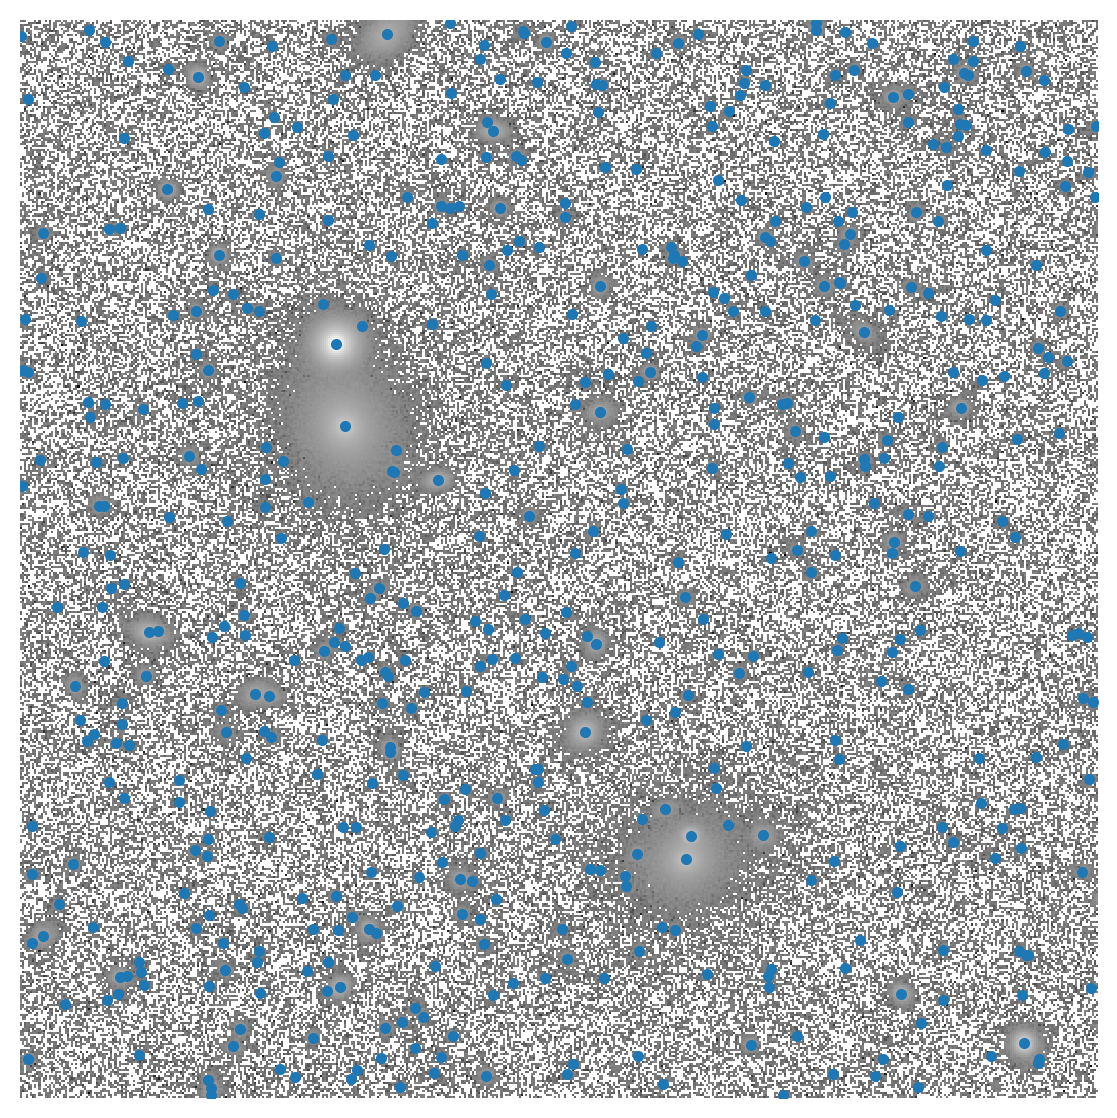

In [16]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
#plt.figure(figsize=(7,7))
ax.imshow(datsm[3],norm=colors.LogNorm(),origin='lower')
ax.scatter(dcut['new_x'].values,dcut['new_y'].values,marker='.')
ax.axis('off')

#ax[1].imshow(datsm2[3],norm=colors.LogNorm(),origin='lower')
#ax[1].scatter(dcut2['new_x'].values,dcut2['new_y'].values,marker='.')
#ax[1].axis('off')

In [15]:
filters = ['u','g','r','i','z','y']


def generate_training_data_example(dirpath, tract, patch, sp, outdir, plot_image=False, plot_stretch_Q=False, plot_scene=False,
                                   plot_likelihood=False, write_results=True):
    """
    Parameters
    ----------
    c : SkyCoord object
          The ra, dec pointing (single or lists of pointings)
    plot_image : bool
          Whether or not to plot the image
    plot_stretch_Q : bool
          Whether or not to plot different normalizations of your image using the stretch, Q parameters.
    plot_scene : bool
           Whether or not plot scene with scarlet
    plot_likelihood : bool
           Whether or not plot the log likelihood of the scarlet fitting
    write_results : bool
          Whether or not to write results to FITS file
    cutout_size : [int, int]
          Cutout shape of image
          
    Returns
    -------
    The scarlet image test in FITS files.
    
    """
    print(tract,patch,sp)
    print()
    
    datas,dcut,psf = get_cutout_cat(dirpath,dall,allcatalog,'id',tract=tract,patch=patch,sp=sp,nblocks=nb)
    cut = np.where(dcut['mag_i'].values<25.3)[0]
    dcut = dcut.iloc[cut]
    
    #cutout,datas,psf = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nb,filters=filters,plot=False)


    ### Run scarlet on image ###

    # HSC pixel scale in arcsec/pixel
    ps = 0.2
    # Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
    sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
    
    
    #psf = np.load(f'/home/g4merz/DC2/nersc_data/data/psfs/{tract}_{patch}_0_psfs.npy')
    
    # Run Scarlet
    out = detection.run_scarlet(datas, filters, catalog=dcut, lvl=2, sigma_model=1, sigma_obs=sigma_obs, psf=psf, plot_scene=plot_scene,
                         max_chi2=1000000, morph_thresh=1, stretch=1, Q=5, 
                         plot_wavelet=False, plot_likelihood=plot_likelihood, plot_sources=False, add_ellipses=False,
                         add_labels=False, add_boxes=False, lvl_segmask=2, maskthresh=0.005,return_models=False)

    # Unpack output
    #observation, starlet_sources, model_frame, catalog, catalog_deblended, segmentation_masks = out
    observation, starlet_sources, model_frame, catalog, segmentation_masks = out

    
    # Save Scarlet data to FITS file
    if write_results:
        filenames = process.write_scarlet_results_nomodels(datas, observation, starlet_sources, model_frame, 
                                             segmentation_masks, outdir=outdir, 
                                             filters=filters, s=f'{tract}_{patch}_{sp}', source_catalog=catalog)
    
        print(f'\nSaved scarlet results as {filenames} \n')
    
        

In [16]:
import importlib
importlib.reload(deepdisc.preprocessing.process)


<module 'deepdisc.preprocessing.process' from '/home/g4merz/deepdisc/src/deepdisc/preprocessing/process.py'>

In [19]:
%%time
outdir='./'
nb=8
generate_training_data_example(dirpath, tract='3828',patch='1,2',sp=4,plot_scene=False, plot_likelihood=False, write_results=True, outdir=outdir)


3828 1,2 4

(6, 4200, 4200)
[525, 525]


/tmp/ipykernel_3239168/2061951149.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_3239168/2061951149.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]


Source catalog has  182 objects
Initializing starlet sources to be fit.


No flux in morphology model for source at (209.72048181298032, 267.9881317471154)
No flux in morphology model for source at (188.5293816510548, 97.34488385190161)
No flux in morphology model for source at (358.268929609163, 509.186786307735)
No flux in morphology model for source at (175.53232860311982, 121.8747957374926)
No flux in morphology model for source at (24.594526692611907, 103.16194218067358)
No flux in morphology model for source at (399.01324522401774, 9.941506946473964)
No flux in morphology model for source at (396.6881047666475, 398.57640248103326)
No flux in morphology model for source at (497.8045912824191, 396.22481004178735)
No flux in morphology model for source at (391.2592264122586, 229.09565006552657)
No flux in morphology model for source at (18.388651363947247, 3.547778266623027)
No flux in morphology model for source at (405.2788180630714, 227.80441014273856)
No flux in morphology model for source at (81.76320703214515, 263.2321413857162)
No flux in morpholog

Fitting Blend model.
Scarlet ran for 15 iterations to logL = -2321654.6215960835
69.64574384689331
Extracting deblended catalog.

Saved scarlet results as {'img_U': './U_3828_1,2_4_scarlet_img.fits', 'img_G': './G_3828_1,2_4_scarlet_img.fits', 'img_R': './R_3828_1,2_4_scarlet_img.fits', 'img_I': './I_3828_1,2_4_scarlet_img.fits', 'img_Z': './Z_3828_1,2_4_scarlet_img.fits', 'img_Y': './Y_3828_1,2_4_scarlet_img.fits', 'segmask': './3828_1,2_4_scarlet_segmask.fits'} 

CPU times: user 1min 27s, sys: 2.68 s, total: 1min 30s
Wall time: 1min 30s


#### The function below will run scarlet on the input images, and output segmentation maps as well as image fits files for each cutout

In [11]:
import multiprocessing
import os
os.cpu_count()
from schwimmbad import MPIPool

In [12]:
pool = MPIPool()

if not pool.is_master():
    pool.wait()
    sys.exit(0)

ValueError: Tried to create an MPI pool, but there was only one MPI process available. Need at least two.

In [ ]:
%%time

processes = 8

tract='3828'
sps = [0,1,2,3,4,5]
patch = '1,2'
outdir = './'
import multiprocessing
from itertools import repeat

args = zip(repeat(dirpath), repeat(tract), repeat(patch), sps, repeat(outdir))

t0 = time.time()
with MPIPool.Pool(processes) as pool:
    results = pool.starmap(generate_training_data_example, args)

3828382838283828 38283828 1,2    1,21 1,2
1,21,2  3  
541,2
0


 



2

(6, 4200, 4200)(6, 4200, 4200)(6, 4200, 4200)(6, 4200, 4200)(6, 4200, 4200)(6, 4200, 4200)



[525, 525]
[525, 525]
[525, 525]
[525, 525]
[525, 525][525, 525]



(525, 525)
(525, 525)
(525, 525)
(525, 525)(525, 525)(525, 525)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 56.649746192893  -36.446280991736  
CRPIX : 8000.0  6100.0  
PC1_1 PC1_2  : -5.5555555555586e-05  0.0  
PC2_1 PC2_2  : 0.0  5.5555555555585e-05  
CDELT : 1.0  1.0  
NAXIS : 525  525WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 56.649746192893  -36.446280991736  
CRPIX : 9050.0  6100.0  
PC1_1 PC1_2  : -5.5555555555586e-05  0.0  
PC2_1 PC2_2  : 0.0  5.5555555555585e-05  
CDELT : 1.0  1.0  
NAXIS : 525  525WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 56.649746192893  -36.446280991736  
CRPIX : 8525.0  6100.0  
PC1_1 PC1_2  : -5.5555555555586e-05  0.0  
PC2

/tmp/ipykernel_4122504/2118109156.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_4122504/2118109156.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_4122504/2118109156.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Source catalog has  144 Source catalog has  132objects 
objectsSource catalog has 
 156 objects
Source catalog has  124 objects
Source catalog has Source catalog has  132  149objects 
objects
Initializing starlet sources to be fit.
Initializing starlet sources to be fit.
Initializing starlet sources to be fit.
Initializing starlet sources to be fit.
Initializing starlet sources to be fit.
Initializing starlet sources to be fit.


No flux in morphology model for source at (23.88875948781333, 14.148735416642012)
No flux in morphology model for source at (31.026649771226403, 356.75489354967885)
No flux in morphology model for source at (2.3236244192285085, 287.6496730651743)
No flux in morphology model for source at (25.036734087474542, 202.75029607380566)
No flux in morphology model for source at (69.02672633083148, 394.12007316178097)
No flux in morphology model for source at (80.10660888602615, 68.37773330313485)
No flux in morphology model for source at (42.82964471316336, 495.70519072713614)
No flux in morphology model for source at (72.93380361473646, 325.160840458504)
No flux in morphology model for source at (10.684205231232227, 146.27574100440597)
No flux in morphology model for source at (18.31787813221854, 39.91131744460472)
No flux in morphology model for source at (69.03617122178366, 489.8977778847693)
No flux in morphology model for source at (81.3780045755475, 27.163584173702475)
No flux in morpholo

Fitting Blend model.
Scarlet ran for 5 iterations to logL = -1535864.432194377
40.49541902542114
Extracting deblended catalog.

Saved scarlet results as {'img_U': './U_3828_1,2_0_scarlet_img.fits', 'model_U': './U_3828_1,2_0_scarlet_model.fits', 'img_G': './G_3828_1,2_0_scarlet_img.fits', 'model_G': './G_3828_1,2_0_scarlet_model.fits', 'img_R': './R_3828_1,2_0_scarlet_img.fits', 'model_R': './R_3828_1,2_0_scarlet_model.fits', 'img_I': './I_3828_1,2_0_scarlet_img.fits', 'model_I': './I_3828_1,2_0_scarlet_model.fits', 'img_Z': './Z_3828_1,2_0_scarlet_img.fits', 'model_Z': './Z_3828_1,2_0_scarlet_model.fits', 'img_Y': './Y_3828_1,2_0_scarlet_img.fits', 'model_Y': './Y_3828_1,2_0_scarlet_model.fits', 'segmask': './3828_1,2_0_scarlet_segmask.fits'} 



#### Now we can utilize some preprocessing functions

In [22]:
from deepdisc.data_format.file_io import DDLoader
from deepdisc.data_format.annotation_functions.annotate_dc2 import annotate_dc2

Here we create a DDLoader class, which helps gather output files and format them

In [5]:
outdir = '/home/g4merz/DC2/nersc_data/data/'
loader = DDLoader().generate_filedict(outdir, ['U', 'G', 'R', 'I', 'Z','Y'], '*_scarlet_img.fits', '*_scarlet_segmask.fits')
filedict = loader.filedict
img_files = np.transpose([filedict[filt]["img"] for filt in filedict["filters"]])


Here we randomly split the datasets into "train" and "test" directories, with 2 cutouts each.  These new directories are created inside `splitdirs`

In [7]:
len(img_files)

6

In [8]:
splitdirs = '/home/shared/hsc/DC2/scarlet_out/'
loader.random_sample(splitdirs,nfiles=[4,2])

Generate a new filedict for the new train directory

In [9]:
loader = DDLoader().generate_filedict('/home/shared/hsc/DC2/scarlet_out/train/', ['U', 'G', 'R', 'I', 'Z','Y'], '*_scarlet_img.fits', '*_scarlet_segmask.fits')
filedict = loader.filedict
img_files = np.transpose([filedict[filt]["img"] for filt in filedict["filters"]])

Use a preprocessing function to turn the single-band fits images into a multi-band numpy array


In [25]:
import importlib
importlib.reload(deepdisc.data_format.conversions)

importlib.reload(deepdisc.data_format.annotation_functions.annotate_dc2)
from deepdisc.data_format.conversions import fitsim_to_numpy #, fits_to_hdf5
from deepdisc.data_format.annotation_functions.annotate_dc2 import annotate_dc2


In [19]:
os.path.basename(img_files[0][0])

'U_3828_1,2_0_scarlet_img.fits'

In [20]:
fitsim_to_numpy(img_files,'/home/shared/hsc/DC2/scarlet_out/train/')

Additional functionality not covered in this notebook

In [26]:

#This is used to create a dataset_dict in the deepdisc format.  It is necessary for training.  
#However, the code assumes you have used an input catalog to get ground truth redshifts and object classes, which we have skipped here

d='train'
dataset_dicts={}
dataset_dicts[d] = loader.generate_dataset_dict(annotate_dc2).get_dataset()  


#This is used to flatten images for RAIL

#fitsim_to_hdf5(img_files,'/home/g4merz/deepdisc/tests/train/',dset='train')



### Save WCS

In [11]:

from deepdisc.data_format.file_io import get_data_from_json

def get_cutout_wcs(dirpath,tract,patch,sp,nblocks=4,filters=['u','g','r','i','z','y']):
    '''
        WARNING!!!!!
        It is not efficient to have the full catalog (defined here as dall) as input to a function when doing multiprocesing.  
        Keep it in the top level process
    '''
    cutout,datsm, psf = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nblocks,filters=filters,plot=False, get_psf=True)
    
    return cutout.wcs

In [144]:
cutout_wcs = get_cutout_wcs(dirpath,3828,'1,2',4,nblocks=8)
cutout_wcs2 = get_cutout_wcs(dirpath,3829,'5,3',4,nblocks=8)

(6, 4200, 4200)
[525, 525]
(6, 4200, 4200)
[525, 525]


In [145]:
wcs_str = cutout_wcs.to_header_string()
wcs_str2 = cutout_wcs2.to_header_string()

In [146]:
wcs_list = [wcs_str,wcs_str2]

In [151]:
import json
with open('wcs_test.json', 'w', encoding='utf-8') as f:
    json.dump(wcs_list, f, ensure_ascii=False, indent=4)

In [152]:
wcs_d = get_data_from_json('wcs_test.json')

In [159]:
def get_cutout_cat_wcs(dirpath,wcs, dcat,skycoords, id_col, tract,patch,sp,nblocks=4,filters=['u','g','r','i','z','y']):
    '''
        WARNING!!!!!
        It is not efficient to have the full catalog (defined here as dall) as input to a function when doing multiprocesing.  
        Keep it in the top level process
    '''
    cutout,datsm, psf = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nblocks,filters=filters,plot=False, get_psf=True)
    xs,ys = wcs.world_to_pixel(skycoords)

    inds = np.where((xs>=0) & (xs<cutout.shape[1]-1) & (ys>=0) & (ys<cutout.shape[0]-1))[0]
    
    
    dcut = dcat.iloc[inds]
    

    dcut['new_x'] = xs[inds]
    dcut['new_y'] = ys[inds]
    
    #dcut = dcut[dcut['mag_i']<25.3]

    
    column_to_move = dcut.pop(id_col)

    # insert column with insert(location, column_name, column_value)
    dcut.insert(0, id_col, column_to_move)
    dcut.sort_values(by=id_col)
    
    return datsm, dcut, psf

In [166]:
datsm,dcut,psf = get_cutout_cat_wcs(dirpath, wcs_new2, dall, allcatalog, 'id', '3829','5,3',4,nblocks=8)

datsm2,dcut2,psf2 = get_cutout_cat_wcs(dirpath, wcs_new, dall, allcatalog, 'id', '3828','1,2',4,nblocks=8)


(6, 4200, 4200)
[525, 525]


/tmp/ipykernel_615893/879649990.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_615893/879649990.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]


(6, 4200, 4200)
[525, 525]


/tmp/ipykernel_615893/879649990.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_615893/879649990.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]


(-0.5, 524.5, -0.5, 524.5)

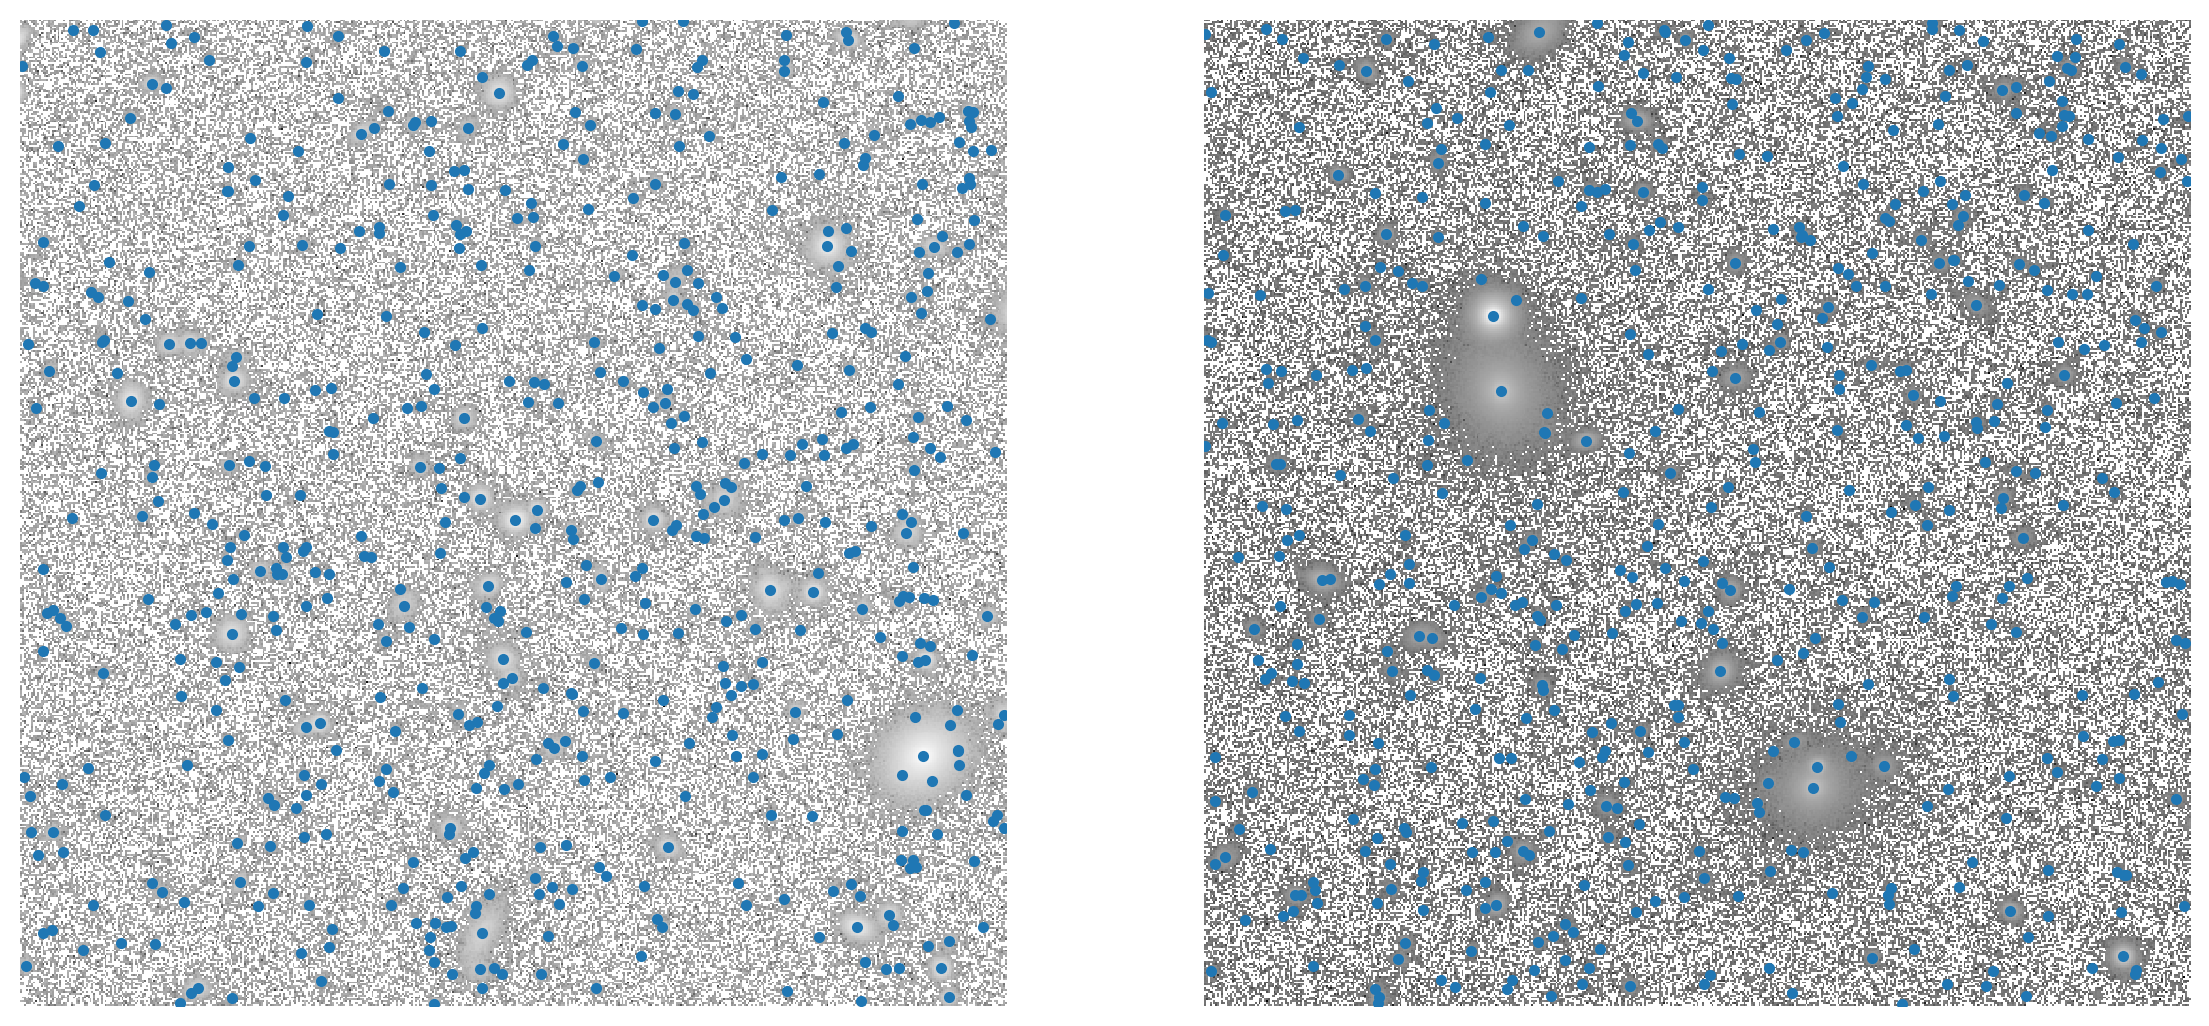

In [167]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
#plt.figure(figsize=(7,7))
ax[0].imshow(datsm[3],norm=colors.LogNorm(),origin='lower')
ax[0].scatter(dcut['new_x'].values,dcut['new_y'].values,marker='.')
ax[0].axis('off')

ax[1].imshow(datsm2[3],norm=colors.LogNorm(),origin='lower')
ax[1].scatter(dcut2['new_x'].values,dcut2['new_y'].values,marker='.')
ax[1].axis('off')

In [12]:
test_dicts = get_data_from_json('/home/g4merz/DC2/nersc_data/test_scarlet_public.json')

In [15]:

wcs_list=[]

for d in test_dicts:
    bn = os.path.basename(d['filename'])
    tract = int(bn.split("_")[0])
    patch = (
        int(bn.split("_")[1].split(",")[0]),
        int(bn.split("_")[1].split(",")[1]),
    )
    sp = int(bn.split("_")[2])
    cutout_wcs = get_cutout_wcs(dirpath,3828,'1,2',4,nblocks=8)
    wcs_list.append(cutout_wcs.to_header_string())

    

In [16]:
import json
with open('test_set_wcs.json', 'w', encoding='utf-8') as f:
    json.dump(wcs_list, f, ensure_ascii=False, indent=4)